# Title

tax 78 % på NPV på petroleum

tax 22 % yearly på profit for WC (med fremførbart underskudd)
##### TODO
 - Legg inn eksisterende bilder i Overleaf
 - Legge til tax
 - Lag siste bilder
 - LCOE 2031 sensitivity
 - Forringelse https://www.nve.no/media/17785/metode-og-forutsetninger-for-beregning-av-kostnader-for-kraftproduksjon.pdf#page=1

## Imports

In [1]:
from scipy.optimize import brentq
import pandas as pd
import traceback

In [2]:
from simulib.cash_flow_models import *
from simulib.visualize import *

## Simulation Results

In [3]:
W = 10000 # number of simulation paths
years = np.arange(2025, 2026+kwargs["LT_field"])

In [4]:
wc_simulation = MonteCarlo(WindContractorPath, 1)
fo_simulation = MonteCarlo(FieldOperatorPath, W)

WindContractorPath Simulation complete at 0 ms
FieldOperatorPath Simulation complete at 338 ms


### Gas

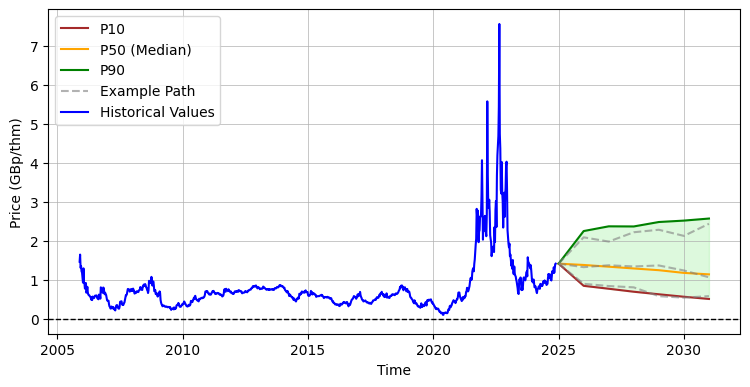

In [5]:
# Load and preprocess historical data
file_path = "Price History_gas_weekly.xlsx - Sheet2.csv"  # Replace with your file path
historical_data = pd.read_csv(file_path)

# Convert "Exchange Date" to datetime
historical_data["Exchange Date"] = pd.to_datetime(historical_data["Exchange Date"], format="%d-%b-%Y")


# Calculate fractional years for each week
historical_data["Year"] = historical_data["Exchange Date"].dt.year
historical_data["Week"] = historical_data["Exchange Date"].dt.isocalendar().week

# Handle cases where Week wraps around (e.g., last days of a year in week 1 of next year)
historical_data["Week"] = historical_data.apply(
    lambda row: row["Week"] + (52 if row["Week"] < 10 and row["Exchange Date"].month == 12 else 0), axis=1
)

# Interpolate fractional years
historical_data["Fractional Year"] = (
    historical_data["Year"] + (historical_data["Week"] - 1) / 52  # Assuming 52 weeks per year
)

# Extract fractional years and corresponding values
historical_years = historical_data["Fractional Year"].values
historical_values = historical_data["Close"].values
all_P_gas = np.array([path.state_variables["P_gas"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years,  # Your simulated years array
    all_P_gas,  # Your simulated state variable paths
    ylabel="Price (GBp/thm)",
    historical_weeks=historical_years,
    historical_values=historical_values,
    save_path="./figures/07_gas_price.png", 
)

### Carbon

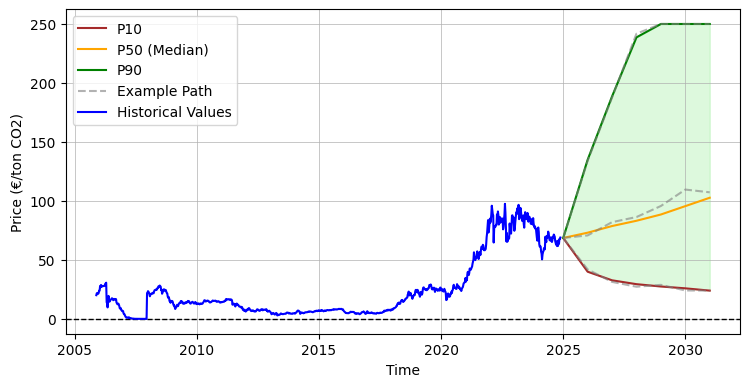

In [6]:
# Load and preprocess historical data
file_path = "Price History_weekly.xlsx - Sheet2.csv"  # Replace with your file path
historical_data = pd.read_csv(file_path)

# Convert "Exchange Date" to datetime
historical_data["Exchange Date"] = pd.to_datetime(historical_data["Exchange Date"], format="%d-%b-%Y")


# Calculate fractional years for each week
historical_data["Year"] = historical_data["Exchange Date"].dt.year
historical_data["Week"] = historical_data["Exchange Date"].dt.isocalendar().week

# Handle cases where Week wraps around (e.g., last days of a year in week 1 of next year)
historical_data["Week"] = historical_data.apply(
    lambda row: row["Week"] + (52 if row["Week"] < 10 and row["Exchange Date"].month == 12 else 0), axis=1
)

# Interpolate fractional years
historical_data["Fractional Year"] = (
    historical_data["Year"] + (historical_data["Week"] - 1) / 52  # Assuming 52 weeks per year
)

# Extract fractional years and corresponding values
historical_years = historical_data["Fractional Year"].values
historical_values = historical_data["Close"].values

all_P_ets = np.array([np.minimum(path.state_variables["P_ets"], 250) for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years,  # Your simulated years array
    all_P_ets,  # Your simulated state variable paths
    ylabel="Price (€/ton CO2)",
    historical_weeks=historical_years,
    historical_values=historical_values,
    save_path="./figures/07_carbon_price.png",
)

## Base Case Results

In [7]:
ppa_price = 1450 # kr/MWh basert på utsira Nord "high"-case

In [8]:
npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
npv_fo = fo_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)

In [9]:
print("NPV WC", f"{int(np.mean(npv_wc) / 1e6):,}".replace(",", " "))
print("NPV FO", f"{int(np.mean(npv_fo) / 1e6):,}".replace(",", " "))
print("NPV Net:", f"{int((np.mean(npv_wc) + np.mean(npv_fo)) / 1e6):,}".replace(",", " "))

NPV WC -78
NPV FO 560
NPV Net: 482


### Wind Contractor’s Perspective

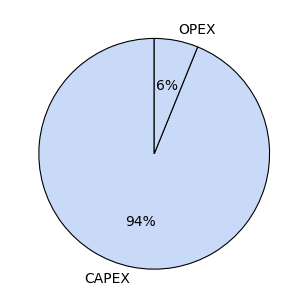

-1236.7224954720882


In [10]:
r = kwargs["r_WC"]

cash_flows = [
    net_present_value(wc_simulation.paths[0].CAPEX_t, r),
    net_present_value(wc_simulation.paths[0].OPEX_t, r)
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "OPEX"
]

plot_contributors_pie(contributors, cash_flows, color="#c9daf8ff", 
                      save_path="./figures/07_costs_wc.png")
print(sum(cash_flows))

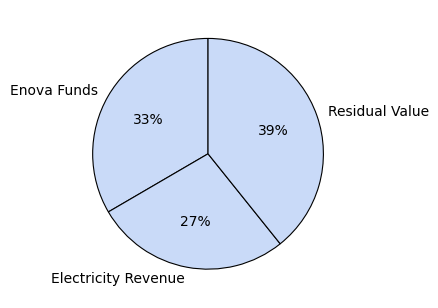

1158.3471572618776


In [11]:
r = kwargs["r_WC"]

cash_flows = [
    net_present_value(wc_simulation.paths[0].CAPEX_support_t, r),
    net_present_value(wc_simulation.paths[0].electricity_revenue_t, r),
    net_present_value(wc_simulation.paths[0].wind_residual_value_t, r),
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "Enova Funds",
    "Electricity Revenue",
    "Residual Value"
]

plot_contributors_pie(contributors, cash_flows, color="#c9daf8ff", 
                      save_path="./figures/07_benefits_wc.png")
print(sum(cash_flows))

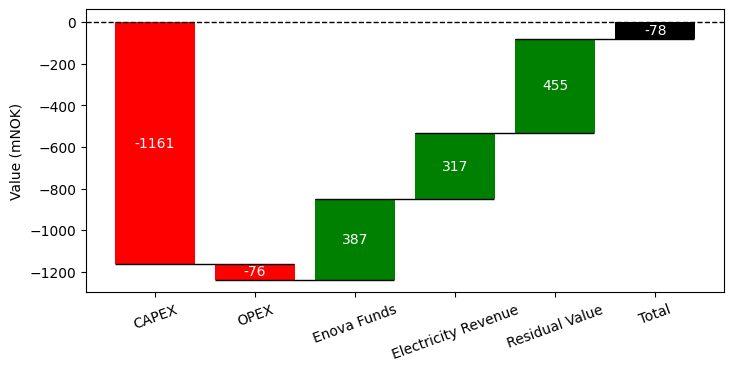

In [12]:
cash_flows = [
    net_present_value(wc_simulation.paths[0].CAPEX_t, r),
    net_present_value(wc_simulation.paths[0].OPEX_t, r),
    net_present_value(wc_simulation.paths[0].CAPEX_support_t, r),
    net_present_value(wc_simulation.paths[0].electricity_revenue_t, r),
    net_present_value(wc_simulation.paths[0].wind_residual_value_t, r),
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "OPEX",
    "Enova Funds",
    "Electricity Revenue",
    "Residual Value"
]

plot_contributors_waterfall(contributors, cash_flows, 
                            save_path="./figures/07_waterfall_wc.png")

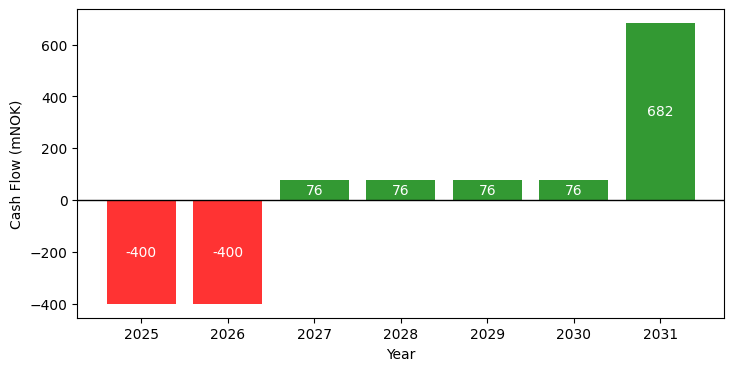

In [13]:
# Call the function
plot_timeline_bar(
    years, 
    wc_simulation.paths[0].cash_flows/1000000, 
    ylabel="Cash Flow (mNOK)",
    save_path="./figures/07_timeline_bar_wc.png"
)


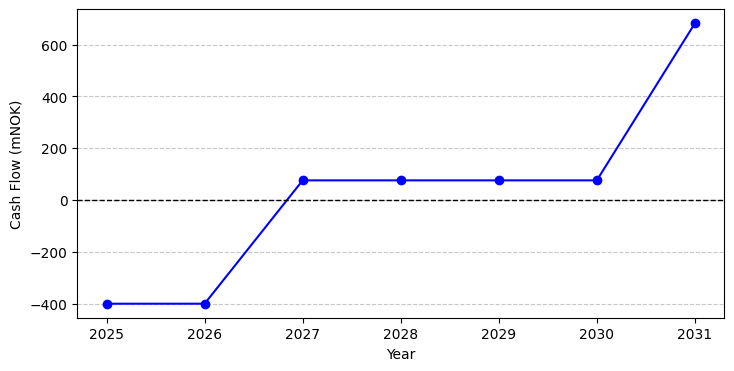

In [14]:
plot_timeline_line(
    years, 
    wc_simulation.paths[0].cash_flows/1000000, 
    ylabel="Cash Flow (mNOK)",
    save_path="./figures/07_timeline_line_wc.png"
)

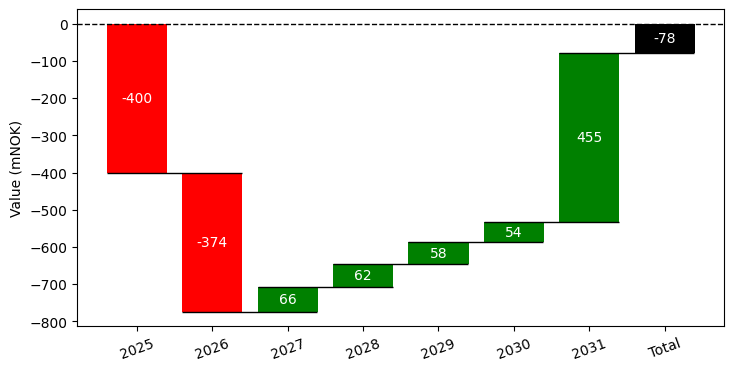

In [15]:
discounted_cash_flows =  (
    wc_simulation.paths[0].cash_flows/1000000 / 
    (1 + r) ** np.arange(len(wc_simulation.paths[0].cash_flows/1000000))
)
plot_contributors_waterfall(list(years.astype(str)), list(discounted_cash_flows), 
                            save_path="./figures/07_timeline_waterfall_wc.png")

### Field Operator Cash Flows

In [16]:
class SpecialPathClass(MonteCarlo.Path):

    def __init__(self, ets, gas) -> None:
        self.ets = ets
        self.gas = gas
        super().__init__()

    def simulate_state_variables(self):
        P_ets_t = self.ets
        P_gas_t = self.gas

        return {"P_ets": P_ets_t, "P_gas": P_gas_t}

    def calculate_cash_flows(self,
        ppa_price,
        CAPEX_FO,
        r_FO,
        t_construction, LT_field,
        wind_annual_power_production,
        gas_CO2_emissions_factor, gas_NOx_emissions_factor,
        start_tax, end_tax, t_tax_ceiling, co2_tax_ceiling,
        NOx_support_rate, NOx_support_ceiling,
        gas_burned_without_owf,
        **kwargs
    ):

        # Capex
        self.CAPEX_FO_t = np.array(
            [-CAPEX_FO/t_construction for i in range(t_construction)] +
            [0 for i in range(LT_field - t_construction)] +
            [0]
        )

        # Carbon costs
        P_ets = np.minimum(self.state_variables["P_ets"], 250) * 11.96 # converted to NOK / tCO2-eq
        self.co2_tax_rate = np.array(
            [start_tax + i * ((end_tax - start_tax)/t_tax_ceiling) for i in range(t_tax_ceiling)] +
            [(0 if P_ets[i] > co2_tax_ceiling else (co2_tax_ceiling - P_ets[i])*gas_CO2_emissions_factor) for i in range(t_tax_ceiling, LT_field + 1)]
        )

        self.avoided_co2_tax_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            ((self.co2_tax_rate)*gas_burned_without_owf)[t_construction:LT_field],
            np.array([0])
        ))

        self.avoided_co2_allowance_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            ((P_ets*gas_CO2_emissions_factor)*gas_burned_without_owf)[t_construction:LT_field],
            np.array([0])
        ))

        # Added gas sales
        P_gas_t = self.state_variables["P_gas"] * 5.360249 # converted to NOK / Sm^3 
        
        self.added_natural_gas_sales_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            (P_gas_t * gas_burned_without_owf)[t_construction:LT_field],
            np.array([0])
        ))
        
        # NOx fund
        self.government_funding_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            np.array([(
                (gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate) 
                if (gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate*(i+1)) < NOx_support_ceiling
                else (
                    NOx_support_ceiling - gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate*(i)
                    if (gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate*(i)) < NOx_support_ceiling
                    else 0
                )
            ) for i in range(LT_field - t_construction)]),
            np.array([0])
        ))

        # Electricity costs (payments to wind contractor)
        self.electricity_costs = - np.array(
            [0 for i in range(t_construction)] +
            [(ppa_price * wind_annual_power_production) for i in range(LT_field - t_construction)] +
            [0]
        )

         
        self.cash_flows = (
            self.CAPEX_FO_t 
            + self.avoided_co2_tax_t + self.avoided_co2_allowance_t 
            + self.added_natural_gas_sales_t
            + self.government_funding_t
            + self.electricity_costs
        )

        return net_present_value(self.cash_flows, r_FO)

In [17]:
r = kwargs["r_FO"]

ets_50 = np.percentile(all_P_ets, 50, axis=0) 
gas_50 = np.percentile(all_P_gas, 50, axis=0) 

special_path = SpecialPathClass(ets_50, gas_50)
special_path.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

464673289.3392784

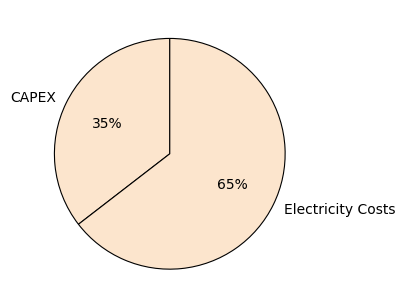

-490.98026231364116


In [18]:
cash_flows = [
    net_present_value(special_path.CAPEX_FO_t, r),
    net_present_value(special_path.electricity_costs, r)
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "Electricity Costs",
]

plot_contributors_pie(contributors, cash_flows, color="#fce5cdff", 
                      save_path="./figures/07_costs_fo.png")
print(sum(cash_flows))

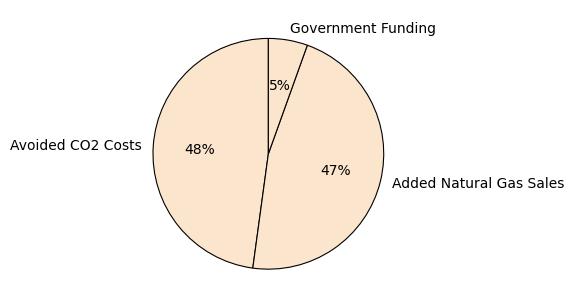

955.6535516529195


In [19]:
cash_flows = [
    net_present_value(special_path.avoided_co2_tax_t, r) + net_present_value(special_path.avoided_co2_allowance_t, r),
    net_present_value(special_path.added_natural_gas_sales_t, r),
    net_present_value(special_path.government_funding_t, r),
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "Avoided CO2 Costs",
    "Added Natural Gas Sales",
    "Government Funding",
]

plot_contributors_pie(contributors, cash_flows, color="#fce5cdff", 
                      save_path="./figures/07_benefits_fo.png")
print(sum(cash_flows))

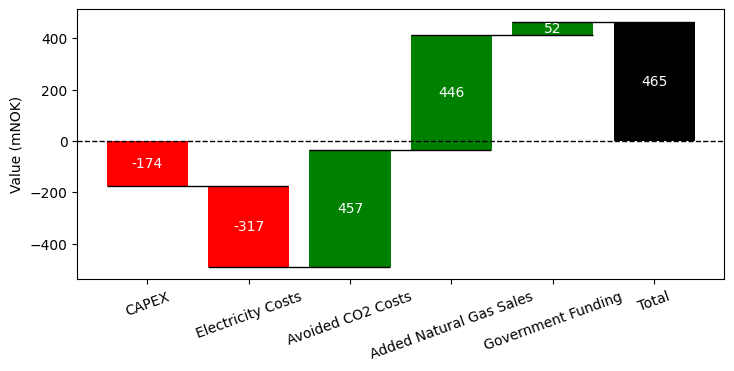

In [20]:
cash_flows = [
    net_present_value(special_path.CAPEX_FO_t, r),
    net_present_value(special_path.electricity_costs, r),
    net_present_value(special_path.avoided_co2_tax_t, r) + net_present_value(special_path.avoided_co2_allowance_t, r),
    net_present_value(special_path.added_natural_gas_sales_t, r),
    net_present_value(special_path.government_funding_t, r),
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "CAPEX",
    "Electricity Costs",
    "Avoided CO2 Costs",
    "Added Natural Gas Sales",
    "Government Funding",
]

plot_contributors_waterfall(contributors, cash_flows, 
                            save_path="./figures/07_waterfall_fo.png")

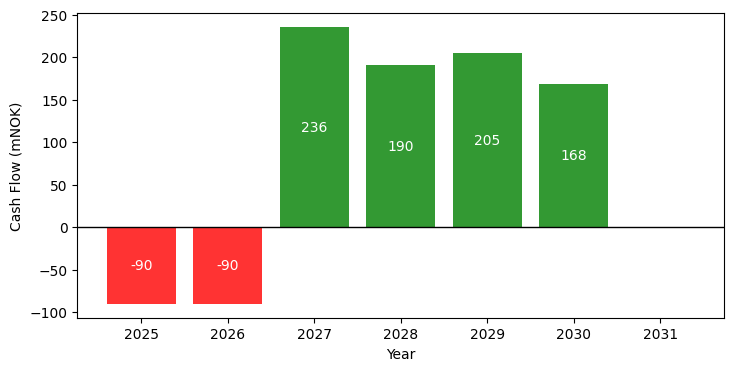

In [21]:
# Call the function
plot_timeline_bar(
    years, 
    special_path.cash_flows/1000000, 
    ylabel="Cash Flow (mNOK)",
    save_path="./figures/07_timeline_bar_fo.png"
)

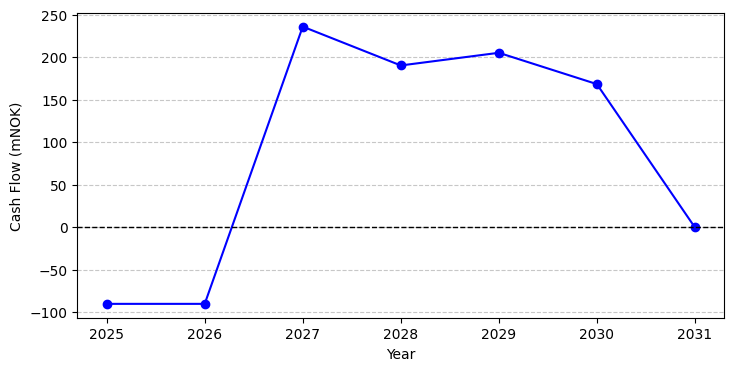

In [22]:
plot_timeline_line(
    years, 
    special_path.cash_flows/1000000, 
    ylabel="Cash Flow (mNOK)",
    save_path="./figures/07_timeline_line_fo.png"
)

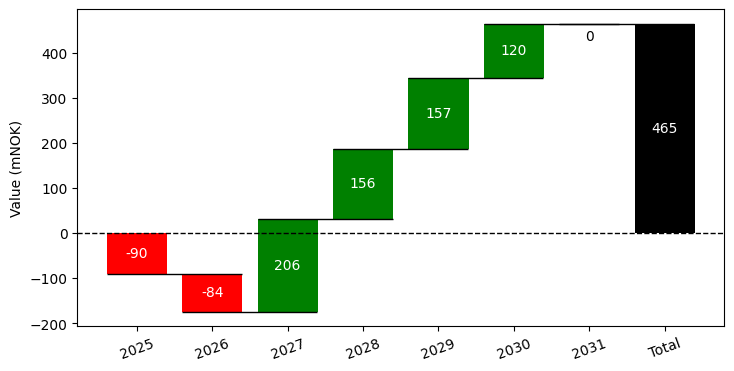

In [23]:
discounted_cash_flows =  (
    special_path.cash_flows/1000000 / 
    (1 + r) ** np.arange(len(special_path.cash_flows))
)
plot_contributors_waterfall(list(years.astype(str)), list(discounted_cash_flows), 
                            save_path="./figures/07_timeline_waterfall_wc.png")

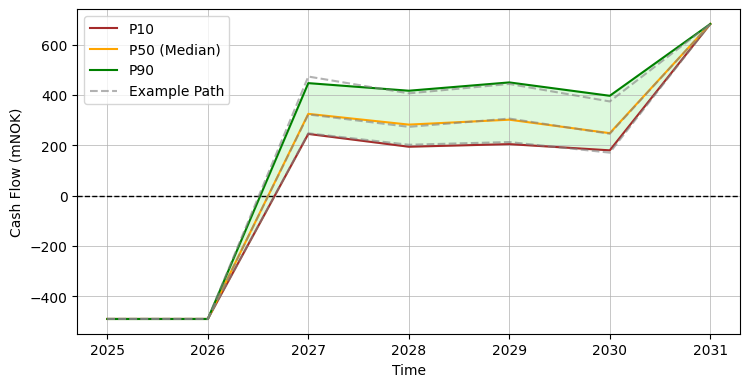

In [24]:
state_variable_paths = np.array([(path.cash_flows+wc_simulation.paths[0].cash_flows)/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    ylabel="Cash Flow (mNOK)",
    save_path="./figures/07_timeline_paths_fo.png"
)


In [25]:
tmp = SpecialPathClass(
    np.array([0]*(kwargs['LT_field']+1)),
    np.array([0]*(kwargs['LT_field']+1))
)
tmp.calculate_cash_flows(ppa_price=ppa_price, **kwargs)
tax_contribution_floor = net_present_value(tmp.avoided_co2_tax_t, r)


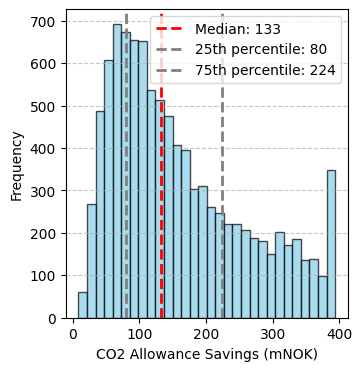

In [26]:
def get_avoided_co2_allowance_t(path):
    tmp = SpecialPathClass(
        path.state_variables['P_ets'],
        path.state_variables['P_gas']
    )
    tmp.calculate_cash_flows(ppa_price=ppa_price, **kwargs)
    return net_present_value(tmp.avoided_co2_allowance_t + tmp.avoided_co2_tax_t, r)

avoided_co2_allowances = np.array(
    [
        get_avoided_co2_allowance_t(path)
        for path in fo_simulation.paths
    ]
)

plot_histogram(
    (avoided_co2_allowances - tax_contribution_floor)/10**6, 
    xlabel="CO2 Allowance Savings (mNOK)",
    width=0.5,
    percentile_lines=[25, 75],
   save_path="./figures/07_npv_contribution_co2_histogram_fo.png"
)

In [27]:
np.mean(avoided_co2_allowances)/3.165617997/10**6

154.90827927742717

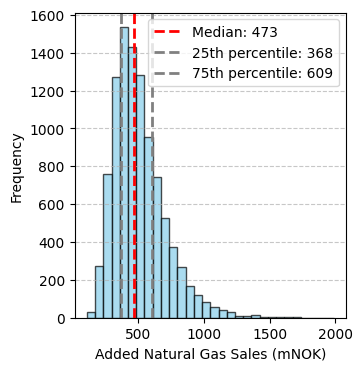

In [28]:
def get_added_natural_gas_sales_t(path):
    tmp = SpecialPathClass(
        path.state_variables['P_ets'],
        path.state_variables['P_gas']
    )
    tmp.calculate_cash_flows(ppa_price=ppa_price, **kwargs)
    return net_present_value(tmp.added_natural_gas_sales_t, r)

added_natural_gas_sales = np.array(
    [
        get_added_natural_gas_sales_t(path)
        for path in fo_simulation.paths
    ]
)

plot_histogram(
    added_natural_gas_sales/10**6, 
    xlabel="Added Natural Gas Sales (mNOK)",
    width=0.5,
    percentile_lines=[25,75],
    save_path="./figures/07_npv_contribution_gas_histogram_fo.png"
)

In [29]:
np.mean(added_natural_gas_sales)/3.165617997/10**6

160.68728212071383

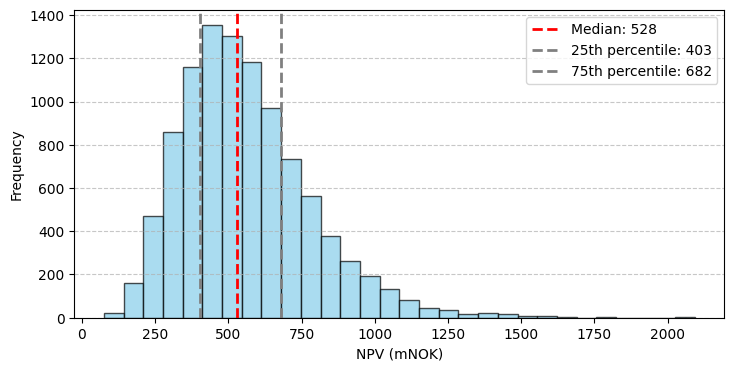

In [30]:
plot_histogram(
    np.array(npv_fo)/10**6, 
    xlabel="NPV (mNOK)",
    percentile_lines=[25, 75],#, 99],
    save_path="./figures/07_npv_histogram_fo.png"
)

Annual means to be used for discussion part

In [31]:
np.mean(special_path.added_natural_gas_sales_t[special_path.added_natural_gas_sales_t != 0]) / 10**6

140.40647120988623

In [32]:
np.mean(special_path.avoided_co2_tax_t[special_path.avoided_co2_tax_t != 0]) / 10**6

91.08424726255741

In [33]:
np.mean(special_path.avoided_co2_allowance_t[special_path.avoided_co2_allowance_t != 0]) / 10**6

53.801120862768734

### Net perspective

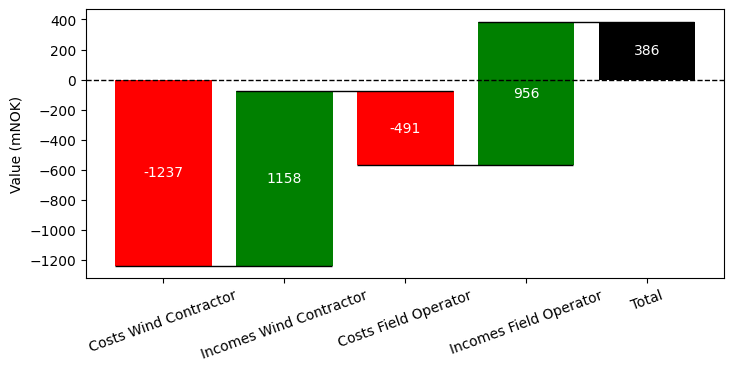

In [34]:
r_WC = kwargs['r_WC']
r_FO = kwargs['r_FO']


cash_flows = [
    ( # Costs wc
        net_present_value(wc_simulation.paths[0].CAPEX_t, r_WC) 
        + net_present_value(wc_simulation.paths[0].OPEX_t, r_WC)
    ),
    ( # Revenues wc
        net_present_value(wc_simulation.paths[0].CAPEX_support_t, r_WC)
        + net_present_value(wc_simulation.paths[0].electricity_revenue_t, r_WC)
        + net_present_value(wc_simulation.paths[0].wind_residual_value_t, r_WC)
    ),
    ( # Costs fo
        net_present_value(special_path.CAPEX_FO_t, r_FO)
        + net_present_value(special_path.electricity_costs, r_FO)
    ),
    ( # Revenues fo
        net_present_value(special_path.avoided_co2_tax_t, r_FO) 
        + net_present_value(special_path.avoided_co2_allowance_t, r_FO)
        + net_present_value(special_path.added_natural_gas_sales_t, r_FO)
        + net_present_value(special_path.government_funding_t, r_FO)
    )
]

cash_flows = [i / 10**6 for i in cash_flows]

contributors = [
    "Costs Wind Contractor",
    "Incomes Wind Contractor",
    "Costs Field Operator",
    "Incomes Field Operator"
]


plot_contributors_waterfall(contributors, cash_flows, 
                            )#save_path="./figures/07_waterfall_fo.png")

In [35]:
contributors

['Costs Wind Contractor',
 'Incomes Wind Contractor',
 'Costs Field Operator',
 'Incomes Field Operator']

# Sensitivity Analyses

## PPA vs. NPV

In [36]:
wc_simulation.calculate_all_cash_flows(ppa_price=1200, **kwargs)


[-133007771.44830191]

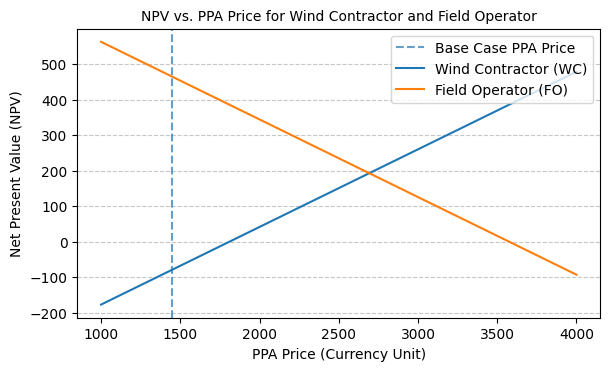

In [37]:
ppa_low = 1000
ppa_high = 4000

ppa_prices = [ppa_low, ppa_high]
wc_npvs = [
    wc_simulation.calculate_all_cash_flows(ppa_price=ppa_low, **kwargs)[0]/10**6,
    wc_simulation.calculate_all_cash_flows(ppa_price=ppa_high, **kwargs)[0]/10**6
]

fo_npvs = [
    SpecialPathClass(ets_50, gas_50).calculate_cash_flows(ppa_price=ppa_low, **kwargs)/10**6,
    SpecialPathClass(ets_50, gas_50).calculate_cash_flows(ppa_price=ppa_high, **kwargs)/10**6
]

# Configure rcParams for consistent styling using update
plt.rcParams.update({
    'font.size': 10,  # Set default font size for all text
    'axes.titlesize': 10,  # Font size for titles
    'axes.labelsize': 10,  # Font size for axis labels
    'xtick.labelsize': 10,  # Font size for x-ticks
    'ytick.labelsize': 10,  # Font size for y-ticks
    'legend.fontsize': 10,  # Font size for legend
    'figure.figsize': (8.27 * 0.75, 11.69 * 0.9 * (6 / 8.27) / 2)  # A4 page with 0.9 linewidth
})

# Create a line graph
plt.figure()


plt.axvline(
    1450, 
    linestyle='--', 
    alpha=0.7,
    label='Base Case PPA Price'
)

plt.plot(ppa_prices, wc_npvs, marker='', label='Wind Contractor (WC)')
plt.plot(ppa_prices, fo_npvs, marker='', label='Field Operator (FO)')


# Add labels, title, and legend
plt.xlabel('PPA Price (Currency Unit)')
plt.ylabel('Net Present Value (NPV)')
plt.title('NPV vs. PPA Price for Wind Contractor and Field Operator')
plt.legend(loc='upper right')

# Show the graph
# plt.grid(True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/07_ppa_sensitivity.png", dpi=300, bbox_inches="tight")
plt.show()

## Sensitivity function

In [77]:
def sensitivity(parameter, percent = 0.2):
    ppa_price_loc = ppa_price
    kwargs_loc = kwargs.copy()
    fo_simulation_loc = fo_simulation

    if parameter == "ppa_price":
        ppa_price_loc = ppa_price*(1+percent)
    elif parameter in kwargs:
        kwargs_loc[parameter] = kwargs[parameter]*(1+percent)
        if parameter=="LT_field":
            kwargs_loc[parameter] = int(kwargs_loc[parameter])

        kwargs_loc["r_FO"] = kwargs_loc["r_WC"]

        # MWh
        kwargs_loc["wind_annual_power_production"] = (
            kwargs_loc["wind_power_rating"] * kwargs_loc["wind_capacity_factor"] * 24 * 365.25
        )

        # NG_const Sm3
        kwargs_loc["gas_burned_without_owf"] = (
            kwargs_loc["wind_annual_power_production"] * 3.6 * 10**3 / (
                kwargs_loc["gas_efficiency_factor"] * 40  # HHV = 40 MJ/Sm3
            )
        )

        kwargs_loc["wind_residual_value"] = (
            (
                kwargs_loc["wind_annual_power_production"]*kwargs_loc["wind_residual_ppa"] # Value assuming PPA-price of 1200
                - kwargs_loc["OPEX"]
            ) * sum(
                [
                    1/(1+kwargs_loc["r_WC"])**i 
                    for i in range(
                        kwargs_loc["LT_turbine"]-kwargs_loc["LT_field"]+kwargs_loc["t_construction"]
                    )
                ]
            )
        ) 

    if ((parameter in gas_schwartz_smith_params) or (parameter in carbon_gbm_params)
            or (parameter == "LT_field")
    ):
        gas_schwartz_smith_params_loc = gas_schwartz_smith_params.copy()
        carbon_gbm_params_loc = carbon_gbm_params.copy()

        carbon_gbm_params_loc[parameter] = (
            carbon_gbm_params.get(parameter, 0)*(1+percent)
        )
        gas_schwartz_smith_params_loc[parameter] = (
            gas_schwartz_smith_params.get(parameter, 0)*(1+percent)
        )

        carbon_gbm_params_loc["period"] = kwargs_loc["LT_field"] + 1
        gas_schwartz_smith_params["period"] = kwargs_loc["LT_field"] + 1

        fo_simulation_loc = MonteCarlo(
            lambda : FieldOperatorPath(carbon_gbm_params_loc, gas_schwartz_smith_params_loc), 
            W
        )
    

    wc_npv = (
        wc_simulation.calculate_all_cash_flows(ppa_price=ppa_price_loc, **kwargs_loc)[0]
    ) / 10**6
        
    fo_npv = (
        np.mean(fo_simulation_loc.calculate_all_cash_flows(ppa_price=ppa_price_loc, **kwargs_loc))
    ) / 10**6

    return wc_npv, fo_npv


In [82]:
parameters = [
    # From kwargs
    "ppa_price",               # External input
    "CAPEX_WC",                # Capital cost for wind contractor
    "CAPEX_FO",                # Capital cost for field operator
    "OPEX",                    # Operational expenses
    "r_WC",                    # Discount rate for wind contractor
    "wind_capacity_factor",    # Capacity factor for wind turbine
    "wind_power_rating",       # Turbine capacity
    "gas_efficiency_factor",   # Efficiency of gas turbines
    "gas_CO2_emissions_factor",# CO2 emissions from gas combustion
    "gas_NOx_emissions_factor",# NOx emissions from gas combustion
    "end_tax",                 # Final gas tax rate
    "co2_tax_ceiling",         # Ceiling for CO2 tax
    "CAPEX_support",           # CAPEX subsidy
    "NOx_support_rate",        # NOx subsidy per kg
    "NOx_support_ceiling",     # Maximum NOx subsidy
    "LT_field",
    "t_construction"

    # # From gas_schwartz_smith_params
    # "xi_0",                    # Initial long-term gas price
    # "sigma_xi",                # Volatility of long-term gas price
    # "mu_xi",                   # Drift of long-term gas price
    # "kappa",                   # Mean reversion speed of long-term gas price
    # "chi_0",                   # Initial short-term gas price
    # "sigma_chi",               # Volatility of short-term gas price
    # "lambda_chi",              # Drift of short-term gas price
    # "rho_xi_chi",              # Correlation between short- and long-term gas prices
    # # From carbon_gbm_params
    # "mu",                      # Drift for carbon price
    # "sigma",                   # Volatility of carbon price
    # "p_0",                     # Initial carbon price
]

In [83]:
# Define the parameters for sensitivity analysis
# parameters = ["ppa_price", "r_WC", "CAPEX_WC", "CAPEX_FO", "wind_capacity_factor", "gas_efficiency_factor"]
percentage_changes = [0.2]  # Changes: -20%, -10%, 0%, +10%, +20%

# Create an empty list to store results
results = []

# Iterate over each parameter and percentage change
for parameter in parameters:
    for percent in percentage_changes:
        try:
            wc_npv, fo_npv = sensitivity(parameter, percent)
            results.append({
                "Parameter": parameter,
                # "Percentage Change": percent * 100,  # Convert to percentage
                "Wind Contractor NPV Impact": wc_npv - npv_wc[0] / 10**6,  # Extract value from tuple
                "Field Operator NPV Impact": fo_npv - np.mean(npv_fo) / 10**6,  # Extract value from tuple
            })
        except Exception as e:
            print(traceback.format_exc())

# Convert results into a DataFrame for visualization
sensitivity_df = pd.DataFrame(results)

sensitivity_df['Net NPV Impact'] = (
    sensitivity_df["Wind Contractor NPV Impact"] + sensitivity_df["Field Operator NPV Impact"]
)

<lambda> Simulation complete at 376 ms
Traceback (most recent call last):
  File "/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_26451/2624419785.py", line 12, in <module>
    wc_npv, fo_npv = sensitivity(parameter, percent)
  File "/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_26451/36972405.py", line 34, in sensitivity
    for i in range(
TypeError: 'float' object cannot be interpreted as an integer



In [84]:
# Displaying the results
sensitivity_df.sort_values('Net NPV Impact', key=abs, ascending=False).style.format(precision=0)

,Parameter,Wind Contractor NPV Impact,Field Operator NPV Impact,Net NPV Impact
5,wind_capacity_factor,191,136,328
6,wind_power_rating,191,136,328
1,CAPEX_WC,-232,0,-232
7,gas_efficiency_factor,0,-167,-167
15,LT_field,11,132,144
4,r_WC,-78,-30,-108
12,CAPEX_support,77,0,77
3,OPEX,-52,0,-52
8,gas_CO2_emissions_factor,0,52,52
10,end_tax,0,37,37


In [85]:
parameters = [
    # From gas_schwartz_smith_params
    "xi_0",                    # Initial long-term gas price
    "sigma_xi",                # Volatility of long-term gas price
    "mu_xi",                   # Drift of long-term gas price
    "kappa",                   # Mean reversion speed of long-term gas price
    "chi_0",                   # Initial short-term gas price
    "sigma_chi",               # Volatility of short-term gas price
    "lambda_chi",              # Drift of short-term gas price
    "rho_xi_chi",              # Correlation between short- and long-term gas prices
    # # From carbon_gbm_params
    # "mu",                      # Drift for carbon price
    # "sigma",                   # Volatility of carbon price
    # "p_0",                     # Initial carbon price
]

In [86]:
# Define the parameters for sensitivity analysis
# parameters = ["ppa_price", "r_WC", "CAPEX_WC", "CAPEX_FO", "wind_capacity_factor", "gas_efficiency_factor"]
percentage_changes = [0.2]  # Changes: -20%, -10%, 0%, +10%, +20%

# Create an empty list to store results
results = []

# Iterate over each parameter and percentage change
for parameter in parameters:
    for percent in percentage_changes:
        try:
            wc_npv, fo_npv = sensitivity(parameter, percent)
            results.append({
                "Parameter": parameter,
                # "Percentage Change": percent * 100,  # Convert to percentage
                "Wind Contractor NPV Impact": wc_npv - npv_wc[0] / 10**6,  # Extract value from tuple
                "Field Operator NPV Impact": fo_npv - np.mean(npv_fo) / 10**6,  # Extract value from tuple
            })
        except Exception as e:
            print(traceback.format_exc())

# Convert results into a DataFrame for visualization
sensitivity_df = pd.DataFrame(results)

sensitivity_df['Net NPV Impact'] = (
    sensitivity_df["Wind Contractor NPV Impact"] + sensitivity_df["Field Operator NPV Impact"]
)

# Displaying the results
sensitivity_df.sort_values('Net NPV Impact', key=abs, ascending=False).style.format(precision=0)

<lambda> Simulation complete at 533 ms
<lambda> Simulation complete at 309 ms
<lambda> Simulation complete at 306 ms
<lambda> Simulation complete at 329 ms
<lambda> Simulation complete at 364 ms
<lambda> Simulation complete at 313 ms
<lambda> Simulation complete at 314 ms
<lambda> Simulation complete at 304 ms


,Parameter,Wind Contractor NPV Impact,Field Operator NPV Impact,Net NPV Impact
0,xi_0,0,37,37
5,sigma_chi,0,20,20
2,mu_xi,0,-13,-13
1,sigma_xi,0,11,11
7,rho_xi_chi,0,-11,-11
3,kappa,0,-7,-7
4,chi_0,0,2,2
6,lambda_chi,0,1,1


In [87]:
parameters = [
    # # From carbon_gbm_params
    "mu",                      # Drift for carbon price
    "sigma",                   # Volatility of carbon price
    "p_0",                     # Initial carbon price
]

In [88]:
# Define the parameters for sensitivity analysis
# parameters = ["ppa_price", "r_WC", "CAPEX_WC", "CAPEX_FO", "wind_capacity_factor", "gas_efficiency_factor"]
percentage_changes = [0.2]  # Changes: -20%, -10%, 0%, +10%, +20%

# Create an empty list to store results
results = []

# Iterate over each parameter and percentage change
for parameter in parameters:
    for percent in percentage_changes:
        try:
            wc_npv, fo_npv = sensitivity(parameter, percent)
            results.append({
                "Parameter": parameter,
                # "Percentage Change": percent * 100,  # Convert to percentage
                "Wind Contractor NPV Impact": wc_npv - npv_wc[0] / 10**6,  # Extract value from tuple
                "Field Operator NPV Impact": fo_npv - np.mean(npv_fo) / 10**6,  # Extract value from tuple
            })
        except Exception as e:
            print(traceback.format_exc())

# Convert results into a DataFrame for visualization
sensitivity_df = pd.DataFrame(results)

sensitivity_df['Net NPV Impact'] = (
    sensitivity_df["Wind Contractor NPV Impact"] + sensitivity_df["Field Operator NPV Impact"]
)

# Displaying the results
sensitivity_df.sort_values('Net NPV Impact', key=abs, ascending=False).style.format(precision=0)

<lambda> Simulation complete at 405 ms
<lambda> Simulation complete at 311 ms
<lambda> Simulation complete at 309 ms


,Parameter,Wind Contractor NPV Impact,Field Operator NPV Impact,Net NPV Impact
2,p_0,0,27,27
0,mu,0,14,14
1,sigma,0,-11,-11


## CAPEX

In [43]:
CAPEX_low = 000 * 10**6
CAPEX_high = 5000 * 10**6

### Wind Operator

In [44]:
wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)

[-78375338.21021044]

In [45]:
def objective(CAPEX):
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX_WC"] = CAPEX
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, CAPEX_low, CAPEX_high)

In [46]:
int(zero_level/1000000)

1118

### Net Project

In [47]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(CAPEX):
        kwargs_copy = kwargs.copy()
        kwargs_copy["CAPEX_WC"] = CAPEX
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, CAPEX_low, CAPEX_high)/1000000)

In [48]:
np.quantile(zero_levels, 0.1)

1435.755792939796

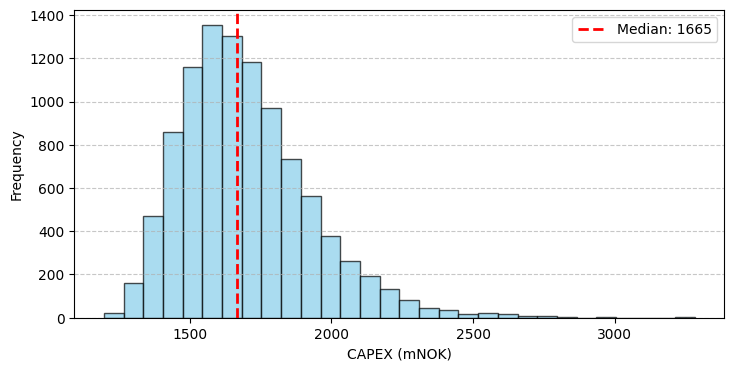

In [49]:
plot_histogram(
    zero_levels, 
    xlabel="CAPEX (mNOK)"
)

## PPA-price

In [50]:
ppa_low = 0
ppa_high = 100000

### Wind Contractor

In [51]:
CAPEX_line = [2000 * 10**6, 4000 * 10**6]
zero_level_line = []

In [52]:
default_CAPEX = kwargs["CAPEX"]
for CAPEX in CAPEX_line:
    kwargs["CAPEX"] = CAPEX
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        return npv

    zero_level_line.append(brentq(objective, ppa_low, ppa_high))

kwargs["CAPEX"] = default_CAPEX

KeyError: 'CAPEX'

In [ ]:
zero_level_line

[]

### Field Operator

In [ ]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return npv

    zero_levels.append(brentq(objective, ppa_low, ppa_high))

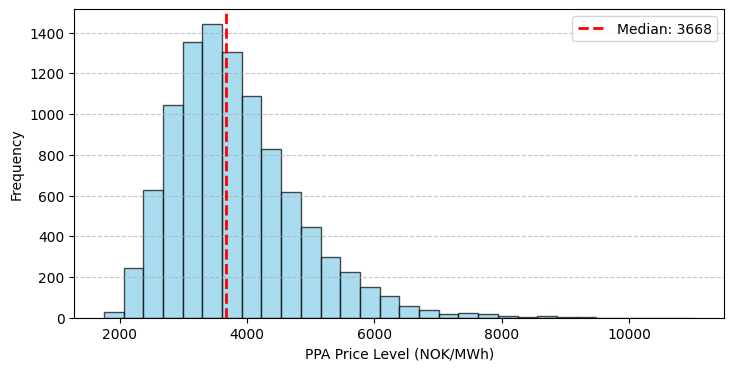

In [ ]:
plot_histogram(
    zero_levels, 
    xlabel="PPA Price Level (NOK/MWh)"
)

## Resale Value

In [ ]:
wind_residual_value_low = -10000 * 10**6
wind_residual_value_high = 10000 * 10**6

### Wind Operator

In [ ]:
objective(0)

1138631447.885313

In [ ]:
def objective(wind_residual_value):
    kwargs_copy = kwargs.copy()
    kwargs_copy["wind_residual_value"] = wind_residual_value
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, wind_residual_value_low, wind_residual_value_high)

In [ ]:
int(zero_level/1000000)

-176

### Net Project

In [ ]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(wind_residual_value):
        kwargs_copy2 = kwargs.copy()
        kwargs_copy2["wind_residual_value"] = wind_residual_value
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)

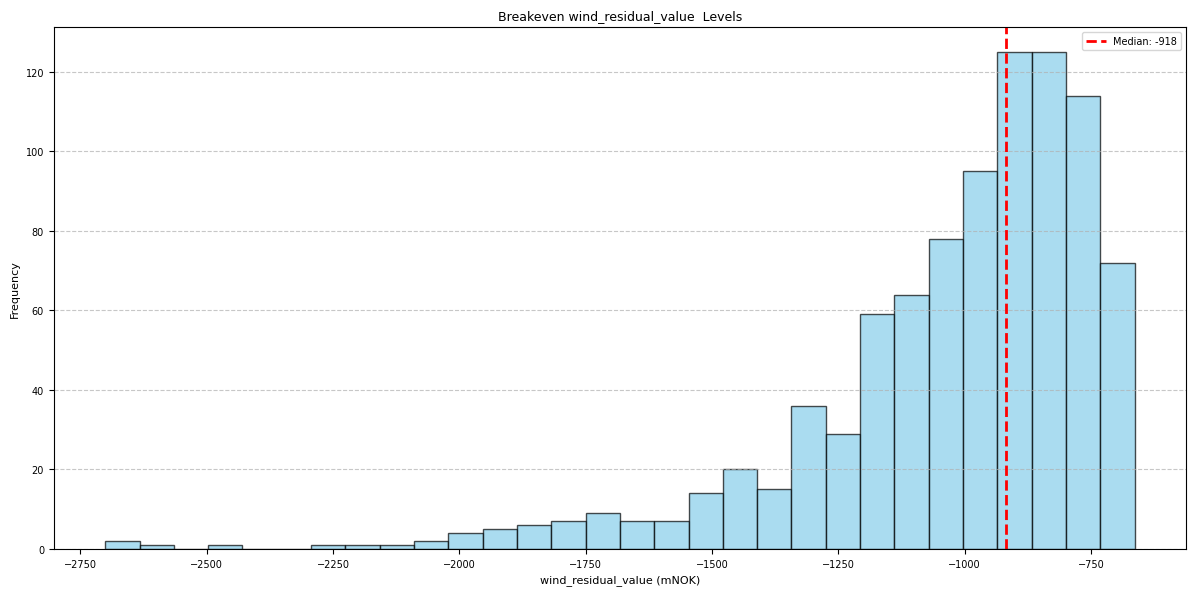

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven wind_residual_value  Levels", 
    xlabel="wind_residual_value (mNOK)"
)

### CAPEX vs Residual Value

In [ ]:
resid_levels_50 = []
resid_levels_90 = []
capex_levels = np.arange(2000, 4001, 2000) * 10 ** 6
for CAPEX in capex_levels:
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX

    zero_levels = []

    for path in fo_simulation.paths:
        def objective(wind_residual_value):
            kwargs_copy2 = kwargs_copy.copy()
            kwargs_copy2["wind_residual_value"] = wind_residual_value
            npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
            npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
            return (npv_wc + npv_fo)

        zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)
    
    resid_levels_50.append(np.median(zero_levels))
    resid_levels_90.append(np.quantile(zero_levels, 0.9))

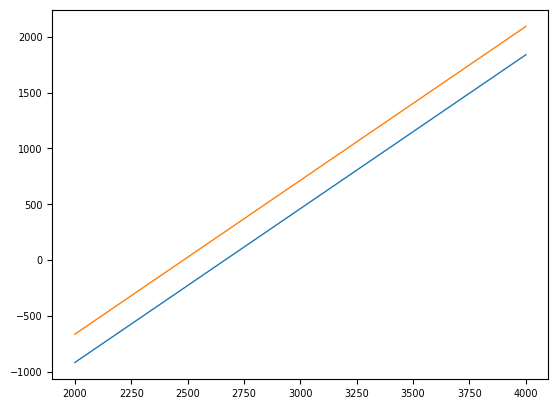

In [ ]:
plt.plot(capex_levels/(10**6), resid_levels_50)
plt.plot(capex_levels/(10**6), resid_levels_90)

## Scenarios

### Low gas scenario

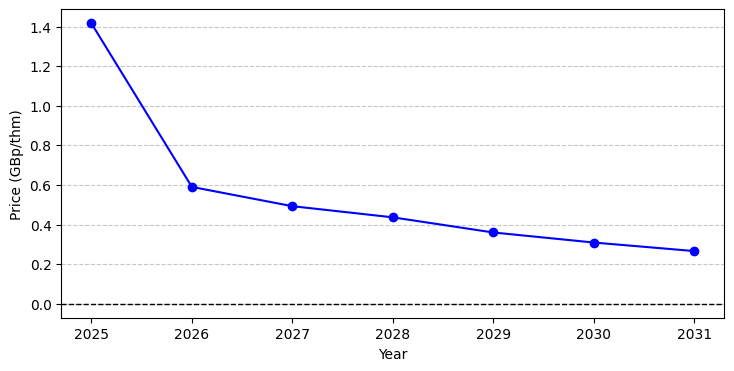

In [ ]:
gas_1 = np.percentile(all_P_gas, 1, axis=0) 

low_gas_scenario = SpecialPathClass(ets_50, gas_1)
low_gas_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

plot_timeline_line(
    years, 
    gas_1, 
    ylabel="Price (GBp/thm)", 
    save_path="./figures/07_low_gas_scenario_gas_price.png"
)

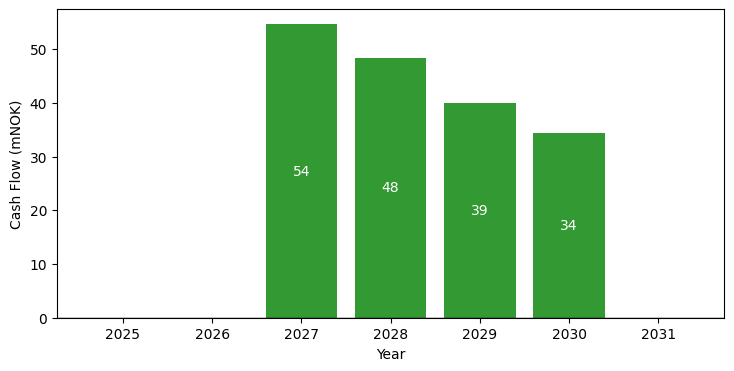

In [ ]:
plot_timeline_bar(
    years, 
    low_gas_scenario.added_natural_gas_sales_t/10**6
)

In [ ]:
np.mean(
    low_gas_scenario.added_natural_gas_sales_t[2:6]
)


44336758.4451048

### Low tax scenario

In [ ]:
low_tax_scenario = SpecialPathClass(np.array([0]*7), gas_50)
low_tax_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

base_case_tax = low_tax_scenario.co2_tax_rate

In [ ]:

low_tax_scenario = SpecialPathClass(np.array([0]*7), gas_50)
tmp = kwargs['end_tax']
kwargs['end_tax'] = 4.80
low_tax_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

low_tax_scenario_tax = low_tax_scenario.co2_tax_rate

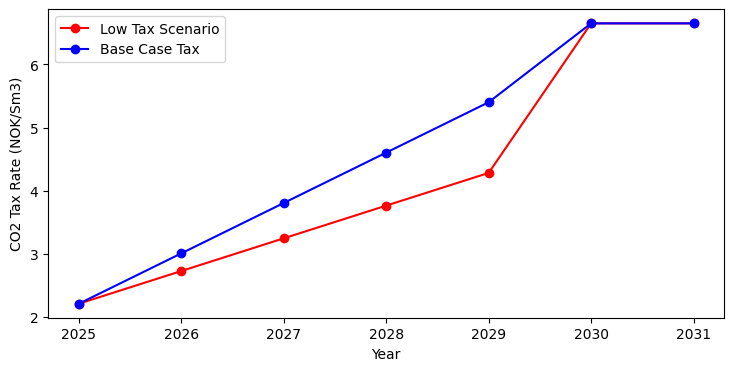

In [ ]:
plt.figure()
plt.plot(years, low_tax_scenario_tax, marker='o', color='red', label="Low Tax Scenario")
plt.plot(years, base_case_tax, marker='o', color='blue', label="Base Case Tax")
plt.xlabel("Year")
plt.ylabel("CO2 Tax Rate (NOK/Sm3)")
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
net_present_value(low_tax_scenario.avoided_co2_tax_t, r)

288213900.1007452

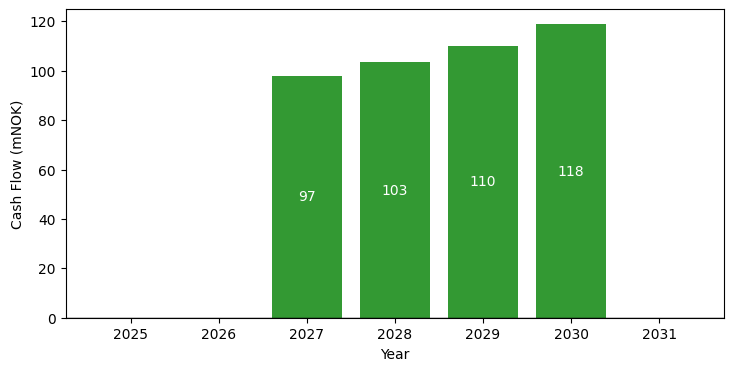

In [ ]:
low_tax_scenario = SpecialPathClass(ets_50, gas_50)
low_tax_scenario.calculate_cash_flows(ppa_price = ppa_price, **kwargs)

plot_timeline_bar(
    years, 
    (low_tax_scenario.avoided_co2_allowance_t + low_tax_scenario.avoided_co2_allowance_t)/10**6
)

In [ ]:
low_tax_scenario.state_variables["P_ets"]

array([ 68.65      ,  73.12186467,  78.75366012,  83.23038037,
        88.53872007,  95.63424897, 102.73366583])

In [ ]:
low_tax_scenario.avoided_co2_tax_t

array([       0.        ,        0.        , 67223605.05      ,
       77951216.7       , 88678828.35      , 78294957.95022966,
              0.        ])

In [ ]:
low_tax_scenario.avoided_co2_allowance_t

array([       0.        ,        0.        , 48960848.05386568,
       51744007.83780447, 55044182.24713444, 59455445.31227034,
              0.        ])

In [ ]:
kwargs['end_tax'] = tmp

***
***
# Junkyard
***


### Net Project

In [ ]:
zero_levels = []

num_npv_negative = 0

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        print(npv_wc, npv_fo, npv_wc + npv_fo)
        return (npv_wc - npv_fo)
    
    zero_levels.append(brentq(objective, ppa_low, ppa_high))
    # except ValueError:
    #     num_npv_negative += 1
    #     continue


-16009157.581164658 917523999.0822761 901514841.5011115
22550409420.936367 -20034575223.54747 2515834197.388897
468072126.3093592 468072126.3093591 936144252.6187183
468072126.30935884 468072126.3093594 936144252.6187181
-16009157.581164658 1023869004.8269771 1007859847.2458124
22550409420.936367 -19928230217.802765 2622179203.133602
523217063.10007197 523217063.1000719 1046434126.2001438
523217063.1000714 523217063.1000725 1046434126.2001438
-16009157.581164658 951207459.0215548 935198301.4403901
22550409420.936367 -20000891763.60819 2549517657.3281784
485538600.2282492 485538600.2282492 971077200.4564984
-16009157.581164658 763176822.4106419 747167664.8294773
22550409420.936367 -20188922400.2191 2361487020.717266
388035783.82407653 388035783.8240765 776071567.6481531
388035783.82407606 388035783.8240769 776071567.648153
-16009157.581164658 890722371.9520608 874713214.3708961
22550409420.936367 -20061376850.67768 2489032570.258686
454174209.5841291 454174209.5841288 908348419.168258
4

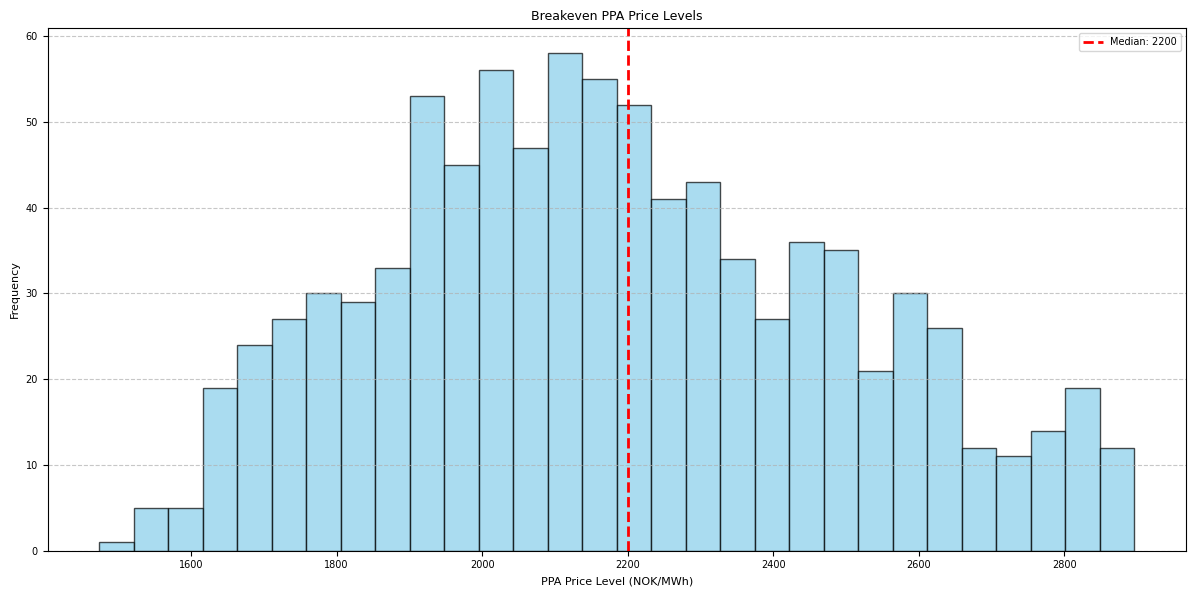

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)